# Load raw data

In [1]:
%matplotlib inline
from pyuvdata import UVCal, UVData
import numpy as np, pylab as P
import aipy, uvtools, hera_cal
import glob

In [2]:
# Get list of files
files = glob.glob("../hera_data/zen.*.xx.HH.uvOR")
print files

['../hera_data/zen.2458042.39396.xx.HH.uvOR', '../hera_data/zen.2458042.14043.xx.HH.uvOR', '../hera_data/zen.2458042.14789.xx.HH.uvOR', '../hera_data/zen.2458042.37159.xx.HH.uvOR', '../hera_data/zen.2458042.15535.xx.HH.uvOR', '../hera_data/zen.2458042.37904.xx.HH.uvOR', '../hera_data/zen.2458042.38650.xx.HH.uvOR', '../hera_data/zen.2458042.17026.xx.HH.uvOR', '../hera_data/zen.2458042.16280.xx.HH.uvOR', '../hera_data/zen.2458042.36413.xx.HH.uvOR']


In [3]:
# See which baselines are included in the dataset
uv = UVData()
uv.read_miriad(files[0]) # This is slow

In [4]:
# Get info about antenna pairs contained in the dataset
aa = hera_cal.utils.get_aa_from_uv(uv)
info = hera_cal.omni.aa_to_info(aa, pols='x', tol=1)

In [5]:
# Find set of redundant baselines with shortest separation
redundant_sets = info.get_reds()
rset0 = []
baseset_keys = []
for rset in redundant_sets:
    if (0,1) in rset:
        # Convert to key strings
        rset0 = rset
        baseset_keys = ",".join( ["%d_%d" % b for b in rset] )
        print rset
print baseset_keys

[(0, 1), (1, 2), (11, 12), (12, 13), (13, 14), (23, 24), (24, 25), (25, 26), (26, 27), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (120, 121), (121, 122), (122, 123), (123, 124), (141, 142), (142, 143)]
0_1,1_2,11_12,12_13,13_14,23_24,24_25,25_26,26_27,36_37,37_38,38_39,39_40,40_41,50_51,51_52,52_53,53_54,54_55,65_66,66_67,67_68,68_69,69_70,70_71,82_83,83_84,84_85,85_86,86_87,87_88,120_121,121_122,122_123,123_124,141_142,142_143


In [6]:
#uv.get_data(int first_ant, int second_ant, 'xx')
#uv.get_flags() #flagged=1
# Don't average over redundant baselines!
d = uv.get_data(rset0[0][0], rset0[0][1], 'xx')
w = uv.get_flags(rset0[0][0], rset0[0][1], 'xx')
w = np.logical_not(w)

divide by zero encountered in log10


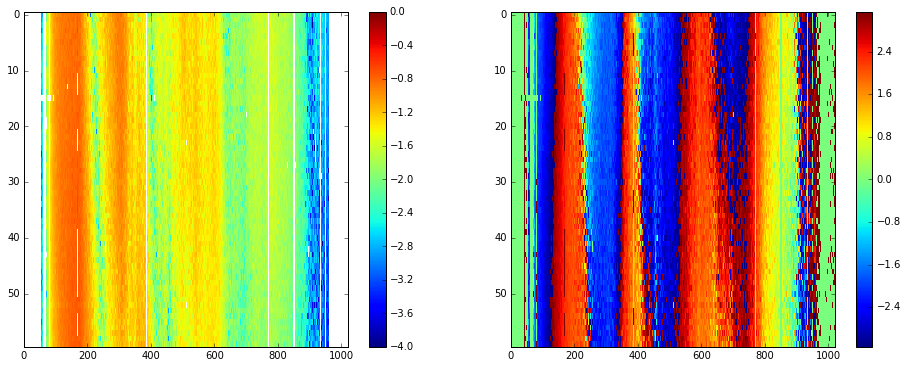

(60, 1024)


In [7]:
P.subplot(121)
uvtools.plot.waterfall(d*w, mode='log', mx=0, drng=4)
P.colorbar()
P.subplot(122)
uvtools.plot.waterfall(d*w, mode='phs')
P.colorbar()
P.gcf().set_size_inches((16., 6.))
P.show()
print d.shape

In [8]:
def est_noise_covariance(d, w, mask_thres=0.98, outlier_thres=95.):
    """
    Estimate frequency-frequency noise covariance by performing finite 
    differences on the data in the time direction and then averaging.
    
    Trims outliers to obtain more reliable results.
    """
    
    # Build frequency mask by dropping channels that have more than a handful 
    # of masked values in the time direction
    #w_freq = np.mean(w, axis=0)
    #w_freq /= np.max(w_freq)
    #w_freq[w_freq < mask_thres] = 0.
    #w_freq[w_freq >= mask_thres] = 1.

    # Create masked array
    #mask = np.logical_not( w.astype(bool) )
    mask = np.logical_not( w.astype(bool) )
    d_masked = np.ma.array(d, mask=mask)
    
    # Difference masked array in the time direction. Assuming that the signal 
    # is almost constant between neighbouring time samples, these values should 
    # essentially be the difference of the noise in neighbouring time samples
    diff_d = np.ma.diff(d_masked, axis=0)
    #sigma = np.std(diff_d, axis=0)
    idxs = np.where(np.abs(diff_d) < 0.1)
    sigma = np.std(diff_d[idxs].real)
    
    idxs = np.where(np.abs(diff_d.imag) < 0.1)
    sigma_i = np.std(diff_d[idxs].imag)
    print diff_d
    print sigma, sigma_i
    
    P.hist(diff_d.flatten(), bins=100, range=(-0.2, 0.2), normed=True)
    xx = np.linspace(-0.1, 0.1, 500)
    P.plot(xx, np.exp(-0.5*(xx/sigma)**2.)/np.sqrt(2.*np.pi)/sigma, 'r-', lw=1.8)
    P.show()
    
    return sigma, np.std(diff_d.real, axis=0), np.std(diff_d.imag, axis=0)
    
    ###########################
    # Trim outliers in each frequency channel to allow better variance estimate
    # (Noise field should be mean-zero, but isn't in practise.)
    percentile = np.nanpercentile(np.abs(diff_d), outlier_thres, axis=0)
    msk = np.zeros(diff_d.shape)
    for i in range(percentile.size):
        idx = np.where(np.abs(diff_d[i]) > percentile[i])
        msk[i][idx] = 1. # FIXME: True or False?
    diff_d_mask = np.ma.array(diff_d, mask=msk.astype(bool))
    std = np.ma.std(diff_d_mask, axis=0)
    return std, percentile

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]
0.009523260936 0.00957305529456


Casting complex values to real discards the imaginary part


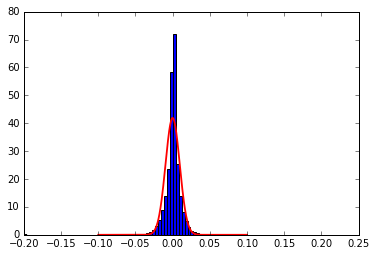

In [9]:
std, sqrtNr, sqrtNi = est_noise_covariance(d, w, mask_thres=0.98, outlier_thres=95.)

In [10]:
def moving_average(a, n=3) :
    ret = np.ma.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    m_avg = ret[n - 1:] / n
    # Pad the beginning with zeros to return vector with same size as input
    m_avg = np.concatenate((np.ma.zeros(n/2), np.ma.filled(m_avg, fill_value=np.nan), np.ma.zeros(n/2-1)))
    return m_avg

invalid value encountered in less_equal


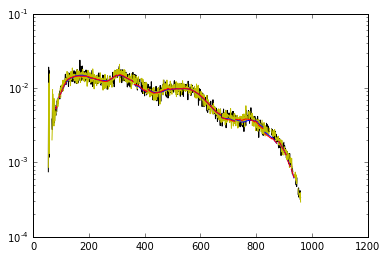

(1024,) (1024,)


In [11]:
P.plot(sqrtNr, 'k-')
P.plot(sqrtNi, 'y-')
P.plot(moving_average(sqrtNr, n=50), 'b-')
P.plot(moving_average(sqrtNi, n=50), 'r-')
P.yscale('log')
P.show()
print sqrtNr.shape, moving_average(sqrtNi, n=50).shape

[ -6.53361212e+05   5.22153534e+06  -1.73417149e+07   2.99439571e+07
  -2.48417865e+07  -1.08702277e+06   2.21819626e+07  -1.60823828e+07
  -6.48554503e+06   2.06825192e+07  -1.88676728e+07   1.02937341e+07
  -3.77155054e+06   9.56469983e+05  -1.67447273e+05   1.97276693e+04
  -1.48390563e+03   6.42006733e+01  -1.20854252e+00]


Polyfit may be poorly conditioned
Polyfit may be poorly conditioned
The fit may be poorly conditioned


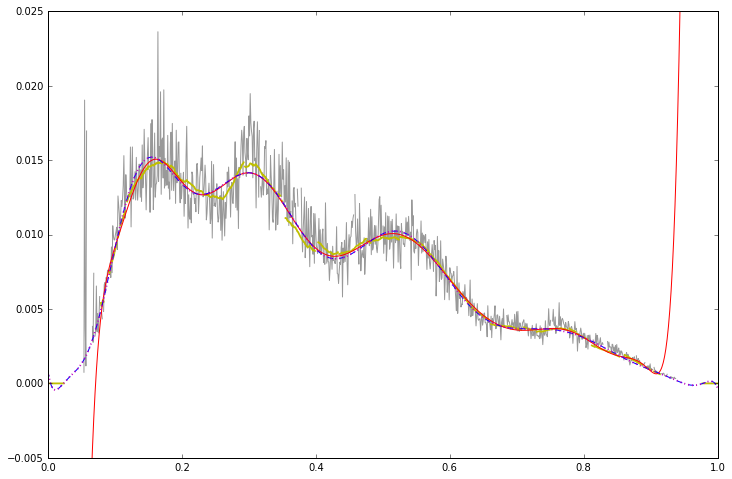

In [12]:
# Fit a polynomial to the movin average
x = np.linspace(0., 1., sqrtNr.size)
avg_r = moving_average(sqrtNr, n=50)
avg_r2 = sqrtNr

# Clean up zeros and NaN values, use those to construct weights
ww = np.ones(x.size)
ww[np.where(np.logical_or(avg_r == 0., np.isnan(avg_r)))] = 0.
avg_r[np.where(np.isnan(avg_r))] = 0.

ww2 = np.ones(x.size)
ww2[np.where(np.logical_or(avg_r2 == 0., np.isnan(avg_r2)))] = 0.
avg_r2[np.where(np.isnan(avg_r2))] = 0.

# Fit polynomial
p = np.polyfit(x, avg_r, deg=18, w=ww)
p2 = np.polyfit(x, avg_r2, deg=18, w=ww2)
ch = np.polynomial.chebyshev.chebfit(x, avg_r2, deg=18, w=ww2)
print p

P.plot(x, sqrtNr, 'k-', alpha=0.4)
P.plot(x, moving_average(sqrtNr, n=50), 'y-', lw=1.8)
P.plot(x, np.polyval(p, x), 'r-')
P.plot(x, np.polyval(p2, x), 'b--')
P.plot(x, np.polynomial.chebyshev.chebval(x, ch), 'm:', lw=1.8)
#P.yscale('log')
P.ylim((-0.005, 0.025))
P.gcf().set_size_inches((12., 8.))
P.show()

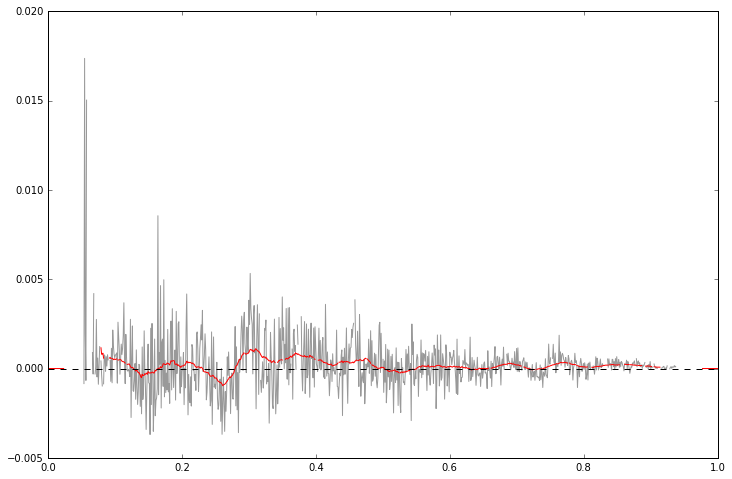

In [13]:
P.plot(x, sqrtNr - np.polyval(p2, x), 'k-', alpha=0.4)
P.plot(x, moving_average(sqrtNr - np.polyval(p2, x), n=50), 'r-')
#P.plot(x, moving_average(sqrtNr, n=50), 'y-', lw=1.8)
#P.plot(x, np.polyval(p, x), 'r-')
#P.plot(x, , 'b--')
#P.yscale('log')
#P.ylim((-0.005, 0.025))
P.axhline(0., color='k', ls='dashed')
P.gcf().set_size_inches((12., 8.))
P.show()